In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [60]:
items_df = pd.read_csv('data/items.csv')
items_df = items_df.query('item_category_id in (3, 12, 20)')
item_ids = items_df['item_id']
item_ids

1386      1386
1389      1389
1415      1415
1496      1496
1501      1501
         ...  
17755    17755
19417    19417
19431    19431
19439    19439
19987    19987
Name: item_id, Length: 229, dtype: int64

d:\venv\mgt\lib\site-packages\pandas\core\tools\datetimes.py:1063: UserWarning: Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\venv\mgt\lib\site-packages\pandas\core\tools\datetimes.py:1063: UserWarning: Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\venv\mgt\lib\site-packages\pandas\core\tools\datetimes.py:1063: UserWarning: Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\venv\mgt\lib\site-packages\pandas\core\tools\datetimes.py:1063: UserWarning: Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

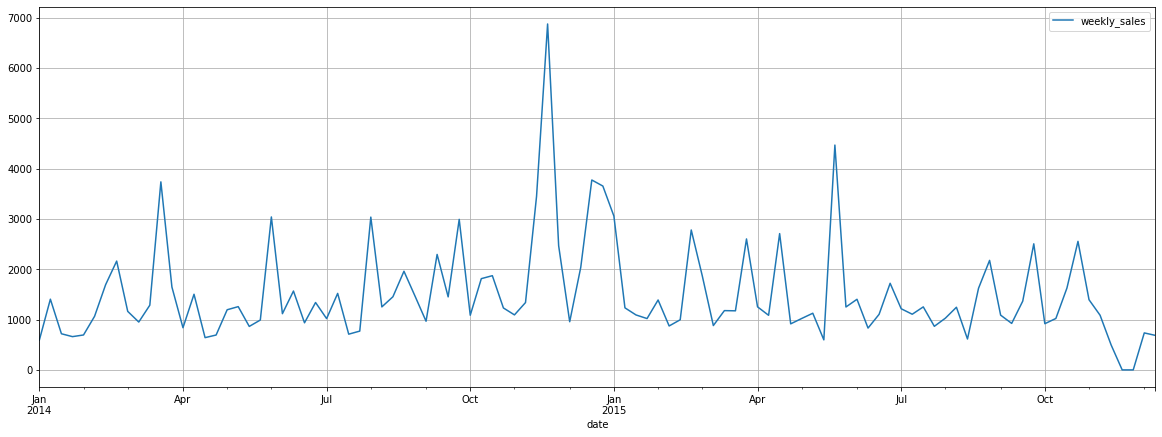

In [61]:
plt.rcParams["figure.figsize"] = (20,7)

df = pd.read_csv('data/sales_train.csv', parse_dates=['date'])
df = df.loc[df['item_id'].isin(item_ids)]
df = df[['date', 'item_cnt_day']]
df = df[(df['date'] > '2014-01-01')]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')



# group data by weekly sales
df_data = df.groupby(pd.Grouper(freq='W')).sum()
df_data = df_data.rename(columns = {'item_cnt_day': 'weekly_sales'})
df_data.plot()
plt.grid()

In [62]:

df_ma = df_data.copy()
df_ma['weekly_sales_diff'] = df_ma['weekly_sales'].diff()
df_ma = df_ma.dropna()
df_ma.count()


weekly_sales         101
weekly_sales_diff    101
dtype: int64

In [63]:
df_ma = df_data.copy()
df_ma['weekly_sales_diff'] = df_ma['weekly_sales'].diff()
df_ma = df_ma.dropna()
df_ma

,weekly_sales,weekly_sales_diff
date,,
2014-01-12,1405.0,814.0
2014-01-19,718.0,-687.0
2014-01-26,661.0,-57.0
2014-02-02,694.0,33.0
2014-02-09,1065.0,371.0
...,...,...
2015-11-15,496.0,-590.0
2015-11-22,0.0,-496.0
2015-11-29,0.0,0.0


In [64]:
df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_ma['weekly_sales_diff'][:(-50+i)]
    #order = (p, d, q) where MA(q)
    model = ARIMA(training_data, order = (0, 0, 2))
    model_fit = model.fit()
    pred_temp = model_fit.get_forecast(1).summary_frame()
    training_data = training_data.append(pred_temp['mean'])
    df_pred = df_pred.append(pred_temp)
# df_pred.dropna()
df_pred

  0%|          | 0/50 [00:00<?, ?it/s]

d:\venv\mgt\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\fourdim\AppData\Local\Temp\ipykernel_25440\1400976122.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_data = training_data.append(pred_temp['mean'])
C:\Users\fourdim\AppData\Local\Temp\ipykernel_25440\1400976122.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred = df_pred.append(pred_temp)
d:\venv\mgt\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\venv\mgt\lib\site-packages\statsmodels\base\model.py

weekly_sales_diff,mean,mean_se,mean_ci_lower,mean_ci_upper
2015-01-04,-886.096345,997.066663,-2840.311095,1068.118404
2015-01-11,-368.874214,988.059530,-2305.435308,1567.686880
2015-01-18,891.138858,997.538017,-1063.999729,2846.277445
2015-01-25,1064.898170,996.974353,-889.135655,3018.931996
2015-02-01,1007.663337,999.279336,-950.888171,2966.214845
2015-02-08,749.700063,993.667319,-1197.852096,2697.252222
2015-02-15,972.912057,998.171974,-983.469063,2929.293177
2015-02-22,918.675925,995.397643,-1032.267606,2869.619457
2015-03-01,-220.672837,992.876517,-2166.675051,1725.329377
2015-03-08,162.935717,988.265171,-1774.028426,2099.899859


In [65]:
df_pred = pd.merge(df_pred, df_ma, how = 'left', left_index = True, right_index = True)
df_pred['weekly_sales_pred'] = df_pred['mean'] + df_ma['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_ma['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['mean_ci_lower'] + df_ma['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['mean_ci_upper'] + df_ma['weekly_sales'].shift()

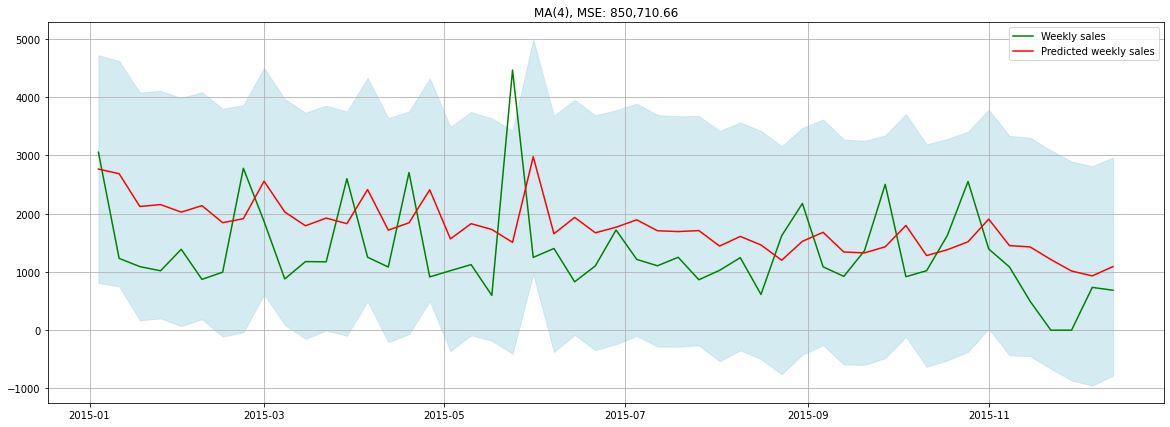

In [66]:


plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('MA(4), MSE: {:,}'.format(round(
                mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.savefig('./MA2.jpg')
plt.show()